In [27]:
import numpy as np 
import celerite
import matplotlib.pyplot as plt
from celerite import terms
import os 
from astropy.table import Table
from astropy.table import vstack
from astropy.table import hstack
from astropy.table import Column

Aim : to fit the mock DRW lightcurves, simulated by Zeljko, with input $\tau=100$ days,  and $\sigma=0.2$.  The errors are 0.01, 0.1 or 0.2.  Lightcurve length is either 365 days : 1 year ('short'),  1000 days ('medium') or 3650 days ('long'). 

Chelsea's results of fitting these light curves with her FORTRAN code are in  ../data_products/Chelsea_results/

In [8]:
# http://docs.astropy.org/en/stable/io/ascii/read.html#io-ascii-read-parameters 
# Read results of Chelsea's fitting 
DirRes = '../data_products/Chelsea_results/'
fname = DirRes + 'fitsshort.dat'
file = open(fname, 'r')
lines =  file.readlines()
colnames = [col.strip()  for col in  lines[1][10:-2].split(",") ]
chelsea_fit = Table.read(fname, format='ascii', names=colnames)

From Chelsea MacLeod,  Dec 1, 2014 

I've attached two data files which list the DRW parameters for the short light curves (fitsshort.dat) and medium length (fitsmed.dat).  These include the *_err3 light curves as well since it was easier for me to just fit everything in the directories.

The third and fourth columns list the two variability parameters tau and sigma-hat, where tau is in log days and sigma-hat is in log mag/sqrt(yr).  You can relate sigma-hat to the long-term rms magnitude (sigma) via 

sigma = sigma-hat $*$ sqrt( tau / (2 $*$365) )

(By the way, when you said sigma=0.2 is the input, do you mean the long-term rms of magnitudes or magnitude differences?    SF_inf is the long-term rms of mag differences and is larger by a factor of sqrt(2). )

The median log(tau) for the short and medium samples are 1.8 and 1.9, respectively. Assuming the input sigma = SF_inf/sqrt(2) = 0.2 mag, then the output sigma is also biased low (median sigma is 0.16 and 0.18 mag, respectively), roughly as expected for these light curve lengths.

In [10]:
# Given the above, lets make two new cols where we express sigma  in mags, and 
# tau in days ...

# recalculate sigma and tau 
chelsea_fit['sigma-hat'] = np.power(10, chelsea_fit['log10(sigma [mag/sqrt(yr)])'])
chelsea_fit['tau'] = np.power(10, chelsea_fit['log10(tau [days])'])
chelsea_fit['sigma'] = chelsea_fit['sigma-hat'].data * np.sqrt(chelsea_fit['tau'].data/(2*365))

# add a column specifying which error we are using ...
chelsea_fit['err'] = np.array([n[-7:-6] for n in chelsea_fit['ID']]).astype(float)



In [12]:
chelsea_fit[:4]

ID,chi^2,log10(tau [days]),log10(sigma [mag/sqrt(yr)]),log10(tau_err_lo),log10(tau_err_hi),log10(sig_err_lo),log10(sig_err_hi),edge flag,Plike,Pnoise,Pinf,mu,npt,sigma-hat,tau,sigma,err
str25,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64
DRWtest_LC1000_err1.dat.2,364.226,1.43239,-0.24917,1.33007,3.55197,-0.29249,-0.257664,0,1110.49,652.784,-1e+32,19.0512,366,0.563417068979,27.0638763144,0.108483470415,1.0
DRWtest_LC1000_err2.dat.2,376.444,1.54391,-0.299187,1.5068,4.15036,-0.448862,-0.275696,0,605.265,528.313,-1e+32,19.0572,366,0.502126335697,34.9872654475,0.109927555356,2.0
DRWtest_LC1000_err3.dat.2,389.758,1.43293,-0.242649,1.33721,3.99117,-0.465347,-0.207985,0,368.44,349.009,-1e+32,19.0667,366,0.571940696611,27.0975483581,0.110193142866,3.0
DRWtest_LC100_err1.dat.2,332.082,1.55067,-0.270387,1.45968,3.88728,-0.328873,-0.26267,0,1125.86,612.69,-1e+32,18.9876,366,0.536553460259,35.5361193657,0.118382244528,1.0


In [17]:
# Read the lightcurves to fit  
DirIn = '../raw_data/DRWtestAllLCshort/'
files = os.listdir(DirIn)
i = 1
print(input_list[i])
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )
lc[:4]

DRWtest_LC1000_err2.dat


time,mag,err
int64,float64,float64
0,19.1645,0.101
1,19.1343,0.101
2,18.9838,0.101
3,19.0271,0.101


True sigma 0.200000, tau 100.000000
      fun: -242.64580339224227
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.45519152e-03,  -6.82121026e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 20
   status: 0
  success: True
        x: array([-3.91216081, -0.28736086])
sigma_fit 0.141412,  tau_fit 1.332905


(100, 150)

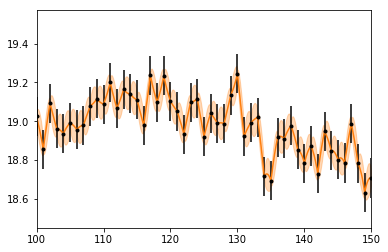

In [15]:
%matplotlib inline
t, y, yerr = lc['time'], lc['mag'], lc['err']
sigma_true = 0.2
tau_true = 100
print('True sigma %f, tau %f'%(sigma_true, tau_true))

# initialize Celerite kernel for DRW 
log_a = 2 * np.exp(sigma_true)
log_c = np.log(1/tau_true)
kernel = terms.RealTerm(log_a = log_a , log_c = log_c)

# wrap the kernel in  a GP object 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

from scipy.optimize import minimize
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

res = gp.get_parameter_dict()
sigma = np.exp(res['kernel:log_a']/2)
tau = 1.0 / np.exp(res['kernel:log_c'])
print("sigma_fit %f,  tau_fit %f"%(sigma,tau))


# plot the prediction 
x = np.linspace(100,150, 1000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlim(100,150)

In [16]:
# Check Chelsea's results for the same object : 

lc_name = input_list[0]+'.2'
m = chelsea_fit['ID'] == lc_name
row = chelsea_fit[m]

print('chelsea fit:  sigma %f,  tau %f'%(np.power(10, row['log10(sigma [mag/sqrt(yr)])']),
                                         np.power(10,row['log10(tau [days])'])))

chelsea fit:  sigma 0.563417,  tau 27.063876


In [18]:
# Loop over all lightcurves ....  3000 in total  

from scipy.optimize import minimize

# all input params are identical .. 
sigma_in = 0.2
tau_in = 100

results = {}
for prior in ['flat', 'log']:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                      'tau_fit':np.zeros(len(files), dtype=float),
                      'name' : np.zeros_like(files)}
for i in range(len(files)) :
    print(i)
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )
    t, y, yerr = lc['time'], lc['mag'], lc['err']
    
    # initialize the kernel ... 
    log_a = 2 * np.log(sigma_in)
    log_c = np.log(1/tau_in)
    kernel = terms.RealTerm(log_a = log_a , log_c = log_c)
    
    # wrap the kernel in  a GP object 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    # minimize the parameters.... 
    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    for prior in ['flat', 'log']:
        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'log' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y)  -log_c + log_a / 2.0
        # perform minimization of the negative log likelihood 
        # to find the maximum   likelihood values ... 
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B",
                     bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        # print("sigma_fit %f,  tau_fit %f"%(sigma_fit,tau_fit))
        results[prior]['sigma_fit'][i] = sigma_fit
        results[prior]['tau_fit'][i] = tau_fit
        results[prior]['name'][i] = files[i]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/celerite/terms.py:288: RuntimeWarning: overflow encountered in exp
  return np.exp(self.log_a), np.exp(self.log_c)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: overflow encountered in exp



288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537

In [20]:
import datetime
# Make a dir for the results 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Celerite_Chelsea_LC_fits',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)



We will save this figure in  /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_Chelsea_LC_fits/2017-06-13/


In [21]:
# Save the results ...
np.save(outDir+'celerite_Ch_short_LC_results.npy', results)        

In [32]:
flat = Table(results['flat'])
log = Table(results['log'])
results_table = hstack([flat,log] , table_names=['flat', 'log'])

In [41]:
results_table.remove_column('name_log')

In [44]:
results_table.rename_column('name_flat', 'name')

In [47]:
# Shorten the ID in Chelsea results to make it match the 
# LC filename  ... 
chelsea_fit.add_column(Column(name = 'name', data = [a[:-2] for a in chelsea_fit['ID'].data]))

In [49]:
# merge celerite and chelsea results on  the LC name  
from astropy.table import join 
combined = join(results_table, chelsea_fit, keys='name', join_type='left')

In [50]:
combined[:4]

sigma_fit_flat,tau_fit_flat,name,sigma_fit_log,tau_fit_log,ID,chi^2,log10(tau [days]),log10(sigma [mag/sqrt(yr)]),log10(tau_err_lo),log10(tau_err_hi),log10(sig_err_lo),log10(sig_err_hi),edge flag,Plike,Pnoise,Pinf,mu,npt,sigma-hat,tau,sigma,err
float64,float64,str23,float64,float64,str25,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64
0.100430993997,23.2671466431,DRWtest_LC1000_err1.dat,0.0934150777396,20.0284139154,DRWtest_LC1000_err1.dat.2,364.226,1.43239,-0.24917,1.33007,3.55197,-0.29249,-0.257664,0,1110.49,652.784,-1e+32,19.0512,366,0.563417068979,27.0638763144,0.108483470415,1.0
0.141412373305,1.33291412022,DRWtest_LC1000_err2.dat,0.140610877319,1.305933878,DRWtest_LC1000_err2.dat.2,376.444,1.54391,-0.299187,1.5068,4.15036,-0.448862,-0.275696,0,605.265,528.313,-1e+32,19.0572,366,0.502126335697,34.9872654475,0.109927555356,2.0
0.230922684592,0.592724704483,DRWtest_LC1000_err3.dat,0.230227228435,0.575528997559,DRWtest_LC1000_err3.dat.2,389.758,1.43293,-0.242649,1.33721,3.99117,-0.465347,-0.207985,0,368.44,349.009,-1e+32,19.0667,366,0.571940696611,27.0975483581,0.110193142866,3.0
0.108587797135,29.8695329571,DRWtest_LC100_err1.dat,0.099895401107,25.1643167962,DRWtest_LC100_err1.dat.2,332.082,1.55067,-0.270387,1.45968,3.88728,-0.328873,-0.26267,0,1125.86,612.69,-1e+32,18.9876,366,0.536553460259,35.5361193657,0.118382244528,1.0


In [51]:
# save the table with results ... 
combined.write(outDir + 'combined_Celerite_Chelsea_results_LC_short.dat', format='ascii')

In [52]:
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

Number of lc with e1 is 1000
Number of lc with e2 is 1000
Number of lc with e3 is 1000
Number of lc with e1 is 1000
Number of lc with e2 is 1000
Number of lc with e3 is 1000


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


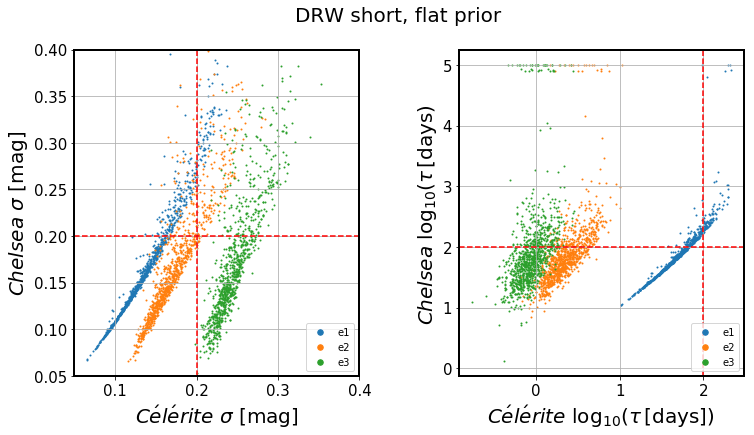

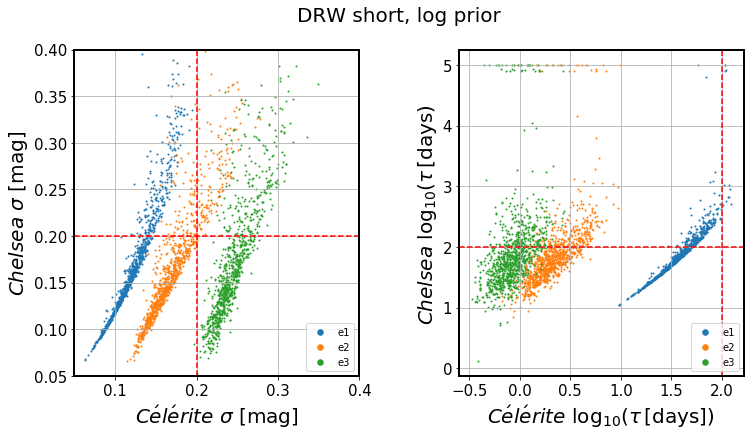

In [104]:
# Plot scatter  of sigma for Celerite vs Chelsea ... 



for prior in ['flat', 'log' ]:
    fig,ax = plt.subplots(1,2, figsize=(12,6))
    for e in [1,2,3] : 
        mask = combined['err'].data == e
        print('Number of lc with e%d is %d'%(e,np.sum(mask)))
        ax[0].scatter(combined['sigma_fit_'+prior][mask],
                   combined['sigma'][mask], s=1, label='e'+str(e))
        x = combined['tau_fit_'+prior][mask]
        y = combined['tau'][mask] 
        
        ax[1].scatter(np.log10(x), np.log10(y),
                    s=1, label='e'+str(e))

    #ax.scatter(0.2,0.2, marker='+', s=390, c='r',linewidth='4')
    #  overplot lines at input values of parameters.... 
    ax[0].axvline(0.2, c='r', ls='--')
    ax[0].axhline(0.2, c='r', ls='--')
    ax[1].axvline(2, c='r', ls='--')
    ax[1].axhline(2, c='r', ls='--')
    # set x and y labels ... 
    ax[0].set_ylabel(r'$Chelsea $ '+r'$\sigma$'+' [mag]')
    ax[0].set_xlabel(r'$C\'el\'erite $ '+r'$\sigma$'+' [mag]')
    ax[1].set_ylabel(r'$Chelsea $ '+r'$\log_{10}{(\tau \, [\mathrm{days})}$'+' ')
    ax[1].set_xlabel(r'$C\'el\'erite $ '+r'$\log_{10}{(\tau \, [\mathrm{days}])} $'+' ')
    ax[0].grid()
    ax[1].grid()
    ax[0].set_ylim(0.05, 0.4)
    ax[0].set_xlim(0.05,0.4)
    fig.suptitle('DRW short, '+prior + ' prior', fontsize=20)
    for axs in ax : 
        legend = axs.legend(loc='lower right')
        for handle in legend.legendHandles:
            handle._sizes = [30]
    fig.subplots_adjust(wspace=0.35)
    plt.savefig(outDir + 'DRWshort_sigma_tau_comparison_'+prior+'.png', bbox_inches='tight')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10


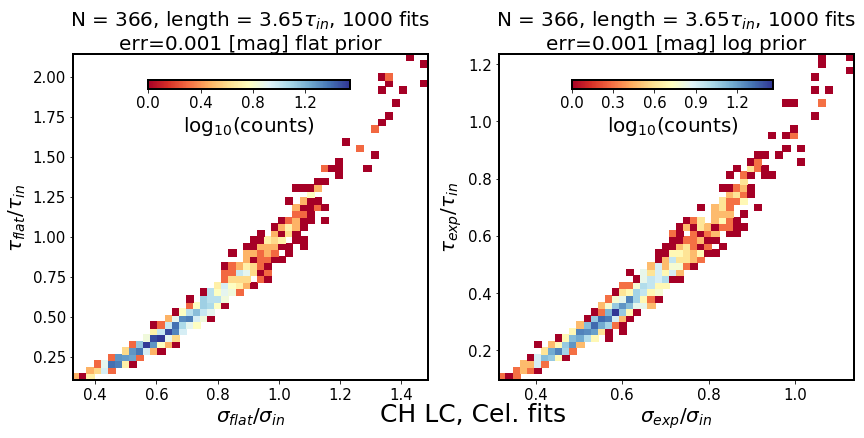

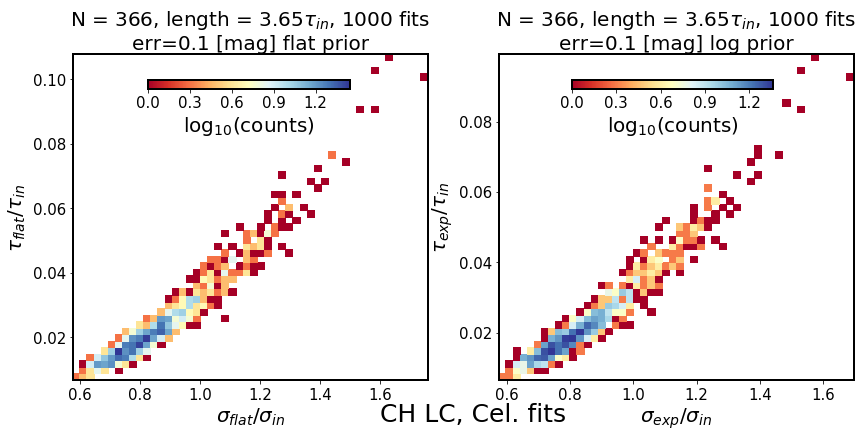

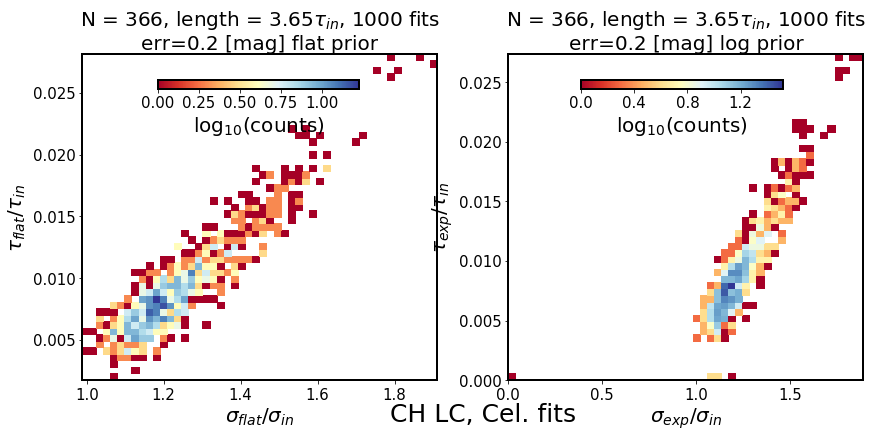

In [105]:
# Plot scatter of input to the output ... 

# Make another plot  : showing  the ratios of   tau_fit to  tau_in  ,  and 
# sigma_fit  to sigma_in 
%matplotlib inline
from scipy.stats import binned_statistic_2d

err = {1 :'0.001' , 2:'0.1' , 3: '0.2'}

for e in [1,2,3] :   # three separate sets of plots .... 
    mask = combined['err'].data == e
    fig,ax = plt.subplots(1,2,figsize=(14,6))
    length = 3.65
    i = 0 
    x0 = [0.2,0.62]
    for prior in ['flat', 'log']:  # left and right panels  
        x = combined['sigma_fit_'+prior][mask] / sigma_in
        y = combined['tau_fit_'+prior][mask] / tau_in

        ax[i].set_title('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
                     +str(len(x))+' fits' + '\n' \
                     + 'err='+err[e]+' [mag] '+ prior +' prior')

        # Plot 2D histogram using pcolor
        stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
        z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
        z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
        z_reduce  =  z_sigma
        z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
        z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
        z_rot_flip = np.flipud(z_rot)
        z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
        image = ax[i].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                                 cmap=plt.cm.get_cmap('RdYlBu'))

        cax = fig.add_axes([x0[i], 0.8, 0.2,0.02])
        colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
        from matplotlib import ticker
        tick_locator = ticker.MaxNLocator(nbins=5)
        colorbar.locator = tick_locator
        colorbar.update_ticks()
        colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

        #xticks = ax[0].get_xticks()
        #ax[0].set_xticks(xticks[::2])
        #ax[i].plot(1,1,marker='+', markersize=30,markerfacecolor='yellow', 
        #     markeredgewidth=10.0)
        #ax[i].plot(1,1,marker='+', markersize=20,markerfacecolor='red', 
        #     markeredgewidth=3.0)
        i += 1 

    ax[0].set_xlabel(r'$\sigma_{flat}/ \sigma_{in}$')
    ax[0].set_ylabel(r'$\tau_{flat} / \tau_{in}$')
    ax[1].set_xlabel(r'$\sigma_{exp}/ \sigma_{in}$')
    ax[1].set_ylabel(r'$\tau_{exp} / \tau_{in}$')

    fig.text(0.43,0.03,'CH LC, Cel. fits', fontsize=25)
    fig.subplots_adjust(wspace=0.2)
    plt.savefig(outDir+'DRW_Celerite_results_linear_e'+str(e)+'.png')


### Plot Chelsea's results... 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_Chelsea_LC_fits/2017-06-13/DRW_short_Chelsea_results_log_all.png
saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_Chelsea_LC_fits/2017-06-13/DRW_med_Chelsea_results_log_all.png
saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_Chelsea_LC_fits/2017-06-13/DRW_long_Chelsea_results_log_all.png


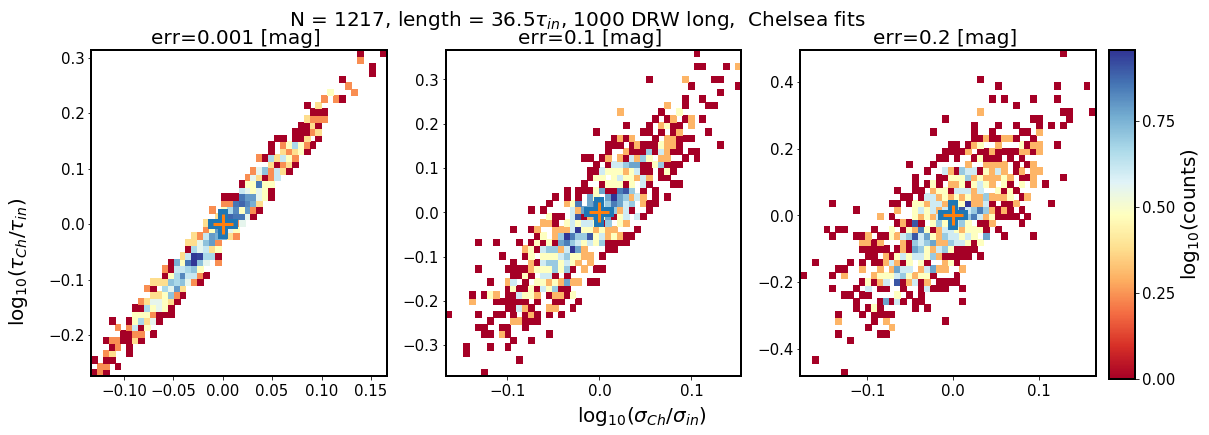

In [143]:
# Read in all Chelsea results...

for lc_leng in ['short', 'med', 'long']: 
    fname = DirRes + 'fits'+lc_leng+'.dat'
    file = open(fname, 'r')
    lines =  file.readlines()
    colnames = [col.strip()  for col in  lines[1][10:-2].split(",") ]
    chelsea_fit = Table.read(fname, format='ascii', names=colnames)

    # recalculate sigma and tau 
    chelsea_fit['sigma-hat'] = np.power(10, chelsea_fit['log10(sigma [mag/sqrt(yr)])'])
    chelsea_fit['tau'] = np.power(10, chelsea_fit['log10(tau [days])'])
    chelsea_fit['sigma'] = chelsea_fit['sigma-hat'].data * np.sqrt(chelsea_fit['tau'].data/(2*365))

    # add a column specifying which error we are using ...
    if lc_leng in ['short', 'med'] : 
        chelsea_fit['err'] = np.array([n[-7:-6] for n in chelsea_fit['ID']]).astype(float)
    else : 
        chelsea_fit['err'] = np.array([n[-5:-4] for n in chelsea_fit['ID']]).astype(float)

    # Plot ratios of output to input 
    # For all Chelsea fits  (short, med ,long )

    %matplotlib inline
    from scipy.stats import binned_statistic_2d

    err = {1 :'0.001' , 2:'0.1' , 3: '0.2'}
    scale = 'log' # log' #  'linear' #  'log'
    tau_in = 100
    sigma_in = 0.2 
    npts = chelsea_fit['npt'][0]
    lc_days = {'short':365, 'med':1000, 'long':3650}
    length = lc_days[lc_leng] / tau_in
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    fig.suptitle('N = '+str(npts)+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
                     +str(len(x))+' DRW '+lc_leng+',  Chelsea fits' + '\n', fontsize=20)
    
    for e in [1,2,3] :   # one plot with three panels
        mask = chelsea_fit['err'].data == e
        x = chelsea_fit['sigma'][mask] / sigma_in
        y = chelsea_fit['tau'][mask] / tau_in

        if scale is 'log' : 
            #print('Using log scale')
            x = np.log10(x)
            y = np.log10(y)

        ax[e-1].set_title('err='+err[e]+' [mag] ')

        # Plot 2D histogram using pcolor
        stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
        z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
        z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
        z_reduce  =  z_sigma
        z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
        z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
        z_rot_flip = np.flipud(z_rot)
        z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
        image = ax[e-1].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                                 cmap=plt.cm.get_cmap('RdYlBu'))
        #xticks = ax[0].get_xticks()
        #ax[0].set_xticks(xticks[::2])
        if scale is 'log' : 
            ax[e-1].plot(0,0,marker='+', markersize=30,markerfacecolor='yellow', 
                 markeredgewidth=10.0)
            ax[e-1].plot(0,0,marker='+', markersize=20,markerfacecolor='red', 
                 markeredgewidth=3.0)
            
    cax = fig.add_axes([0.91, 0.12, 0.02,0.76])
    colorbar = fig.colorbar(image, cax=cax, orientation='vertical')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=4)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

    if scale is 'log' : 
        xlabel = r'$\log_{10}{(\sigma_{Ch}/ \sigma_{in})}$'
        ylabel = r'$\log_{10}{(\tau_{Ch} / \tau_{in})}$'

    else : 
        xlabel = r'$\sigma_{Ch}/ \sigma_{in}$'
        ylabel = r'$\tau_{Ch} / \tau_{in}$'

    fig.text(0.5, 0.02,xlabel, rotation=0, fontsize=20)  
    fig.text(0.06, 0.5, ylabel, rotation=90, fontsize=20)
    #fig.text(0.52,0.03,'', fontsize=25)
    fig.subplots_adjust(wspace=0.2)
    fname = outDir+'DRW_'+lc_leng+'_Chelsea_results_'+scale+'_all.png'
    plt.savefig(fname)
    print('saved as %s'%fname)
